In [1]:
from file import test_complete_system
import numpy as np
from substitute_perbutate import FresnelSubstitution , PixelPerturbation
from PIL import Image
import matplotlib.pyplot as plt

COMBINED ENCRYPTION: SUBSTITUTION + PERTURBATION
Implementation from the research paper

Usage:
  # Perform combined encryption and decryption
  original, substituted, perturbed, inv_perturbed, recovered = \
      combined_encryption('your_image.jpg')

  # Visualize all stages
  visualize_combined_encryption(original, substituted, perturbed, \
                                 inv_perturbed, recovered)


In [2]:
image_to_encrypt = "medical images/Brain MRI.jpg"
biometric_enroll = "biometric images/kelvinl3.jpg"
biometric_probe = "biometric images/kelvinl5.jpg"

In [3]:

def combined_encryption(image_path, seed_d=12345, seed_f=67890, r=3.99, x=0.5):
    """
    Combined encryption: Substitution -> Perturbation -> Inverse Perturbation -> Inverse Substitution
    
    
    Args:
        image_path: Path to the input image
        seed_d: Seed for distance parameter (substitution)
        seed_f: Seed for frequency parameter (substitution)
        r: Logistic map parameter (perturbation)
        x: Initial value for logistic map (perturbation)
        
    Returns:
        original_img, after_substitution, after_perturbation, after_inv_perturbation, final_recovered
    """
    # Load image
    img = Image.open(image_path).convert('L')
    img_array = np.array(img)
    
    print(f"Original image shape: {img_array.shape}")
    height, width = img_array.shape
    
    # ==================== STEP 1: SUBSTITUTION ====================
    print("\n" + "="*60)
    print("STEP 1: SUBSTITUTION")
    print("="*60)
    
    fs = FresnelSubstitution(seed_d=seed_d, seed_f=seed_f)
    substituted_array = np.zeros_like(img_array)
    
    print("Performing substitution...")
    for i in range(height):
        if i % 50 == 0:
            print(f"  Processing row {i}/{height}")
        row = img_array[i, :]
        substituted_row = fs.substitute(row)
        substituted_array[i, :] = substituted_row
    
    print("✓ Substitution complete!")
    
    # ==================== STEP 2: PERTURBATION ====================
    print("\n" + "="*60)
    print("STEP 2: PERTURBATION")
    print("="*60)
    
    pp = PixelPerturbation(r_init=r, x_init=x)
    pp.x_original = x
    
    print("Performing perturbation on substituted image...")
    perturbed_array = pp.perturbate_image(substituted_array.copy())
    print("✓ Perturbation complete!")
    
    return img_array, substituted_array, perturbed_array


In [4]:
[image_array1 , substitued_array1 , perturbed_array1] = combined_encryption(image_path='medical images/Brain MRI.jpg')
[image_array2 , substitued_array2 , perturbed_array2] = combined_encryption(image_path='medical images/fetus ultrasound.jpg')
[image_array3 , substitued_array3 , perturbed_array3] = combined_encryption(image_path='medical images/lung ct scan.jpg')
[image_array4 , substitued_array4 , perturbed_array4] = combined_encryption(image_path='medical images/teeth xray.jpg')

Original image shape: (128, 128)

STEP 1: SUBSTITUTION
Performing substitution...
  Processing row 0/128
  Processing row 50/128
  Processing row 100/128
✓ Substitution complete!

STEP 2: PERTURBATION
Performing perturbation on substituted image...
✓ Perturbation complete!
Original image shape: (128, 128)

STEP 1: SUBSTITUTION
Performing substitution...
  Processing row 0/128
  Processing row 50/128
  Processing row 100/128
✓ Substitution complete!

STEP 2: PERTURBATION
Performing perturbation on substituted image...
✓ Perturbation complete!
Original image shape: (128, 128)

STEP 1: SUBSTITUTION
Performing substitution...
  Processing row 0/128
  Processing row 50/128
  Processing row 100/128
✓ Substitution complete!

STEP 2: PERTURBATION
Performing perturbation on substituted image...
✓ Perturbation complete!
Original image shape: (128, 128)

STEP 1: SUBSTITUTION
Performing substitution...
  Processing row 0/128
  Processing row 50/128
  Processing row 100/128
✓ Substitution complete!

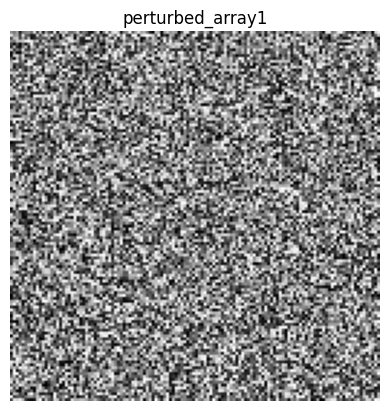

In [5]:
import matplotlib.pyplot as plt

if perturbed_array1 is not None:
    plt.imshow(perturbed_array1, cmap='gray')
    plt.title("perturbed_array1")
    plt.axis('off')
    plt.show()

#### Enroll biometric and encrypt with AES


In [6]:
from helper import enroll_biometric, aes_encrypt_numpy_array

BCH parameters: n=255, k=131, t=18 (correctable errors)
VGG16 model loaded


In [7]:
key, helper_data = enroll_biometric(biometric_enroll)
[ciphertext1, iv1, metadata1] = aes_encrypt_numpy_array(perturbed_array1, key)
[ciphertext2, iv2, metadata2] = aes_encrypt_numpy_array(perturbed_array2, key)
[ciphertext3, iv3, metadata3] = aes_encrypt_numpy_array(perturbed_array3, key)
[ciphertext4, iv4, metadata4] = aes_encrypt_numpy_array(perturbed_array4, key)

[Enrollment] Processing: biometric images/kelvinl3.jpg
[Enrollment] Key generated (32 bytes), Helper data created
[AES Encrypt] Array shape (128, 128), dtype uint8
[AES Encrypt] Plaintext: 16384 bytes → Ciphertext: 16400 bytes
[AES Encrypt] Array shape (128, 128), dtype uint8
[AES Encrypt] Plaintext: 16384 bytes → Ciphertext: 16400 bytes
[AES Encrypt] Array shape (128, 128), dtype uint8
[AES Encrypt] Plaintext: 16384 bytes → Ciphertext: 16400 bytes
[AES Encrypt] Array shape (128, 128), dtype uint8
[AES Encrypt] Plaintext: 16384 bytes → Ciphertext: 16400 bytes


#### Reproduce key from biometric probe

In [8]:
from helper import reproduce_biometric_key

In [9]:
try:
    key = reproduce_biometric_key(biometric_probe, helper_data)
except ValueError as e:
    print(f"\n✗ BIOMETRIC AUTHENTICATION FAILED")
    print(f"   {e}")
    raise

[Reproduction] Processing: biometric images/kelvinl5.jpg
[Reproduction] BCH decoding successful
[Reproduction] Key reproduced successfully (32 bytes)


#### AES decryption

In [10]:
from helper import aes_decrypt_to_numpy_array

In [11]:
try:
    recovered_perturbed_array1 = aes_decrypt_to_numpy_array(
            ciphertext1,
            iv1,
            key,
            metadata1
    )
    recovered_perturbed_array2 = aes_decrypt_to_numpy_array(
            ciphertext2,
            iv2,
            key,
            metadata2
    )
    recovered_perturbed_array3 = aes_decrypt_to_numpy_array(
            ciphertext3,
            iv3,
            key,
            metadata3
    )
    recovered_perturbed_array4 = aes_decrypt_to_numpy_array(
            ciphertext4,
            iv4,
            key,
            metadata4
    )
    
except Exception as e:
    print(f"\n✗ AES DECRYPTION FAILED")
    print(f"   {e}")
    raise

[AES Decrypt] Ciphertext: 16400 bytes → Plaintext: 16384 bytes
[AES Decrypt] Reconstructed array shape (128, 128), dtype uint8
[AES Decrypt] Ciphertext: 16400 bytes → Plaintext: 16384 bytes
[AES Decrypt] Reconstructed array shape (128, 128), dtype uint8
[AES Decrypt] Ciphertext: 16400 bytes → Plaintext: 16384 bytes
[AES Decrypt] Reconstructed array shape (128, 128), dtype uint8
[AES Decrypt] Ciphertext: 16400 bytes → Plaintext: 16384 bytes
[AES Decrypt] Reconstructed array shape (128, 128), dtype uint8


### successfully recovered perturbed_array

In [12]:
# np.abs(recovered_perturbed_array-perturbed_array)

#### INVERSE PERTURBATION

In [13]:
# parameters previously used
seed_d=12345
seed_f=67890
r=3.99
x=0.5

In [14]:
    
pp2 = PixelPerturbation(r_init=r, x_init=x)
pp2.x_original = x
    

In [15]:

inv_subs_array1 = pp2.perturbate_image_inverse(recovered_perturbed_array1.copy())
inv_subs_array2 = pp2.perturbate_image_inverse(recovered_perturbed_array2.copy())
inv_subs_array3 = pp2.perturbate_image_inverse(recovered_perturbed_array3.copy())
inv_subs_array4 = pp2.perturbate_image_inverse(recovered_perturbed_array4.copy())


In [16]:
# import matplotlib.pyplot as plt

# if inv_subs_array is not None:
#     plt.imshow(inv_subs_array, cmap='gray')
#     plt.title("Loaded & Prepared Image")
#     plt.axis('off')
#     plt.show()


#### INVERSE Substitution

In [17]:
fs = FresnelSubstitution(seed_d=seed_d, seed_f=seed_f)
recovered_array1 = np.zeros_like(inv_subs_array1)
recovered_array2 = np.zeros_like(inv_subs_array1)
recovered_array3 = np.zeros_like(inv_subs_array1)
recovered_array4 = np.zeros_like(inv_subs_array1)

In [18]:
height, width = inv_subs_array1.shape


In [19]:
for i in range(height):
        if i % 50 == 0:
            print(f"  Processing row {i}/{height}")
        row = inv_subs_array1[i, :]
        recovered_row = fs.substitute_inv(row)
        recovered_array1[i, :] = recovered_row

for i in range(height):
        if i % 50 == 0:
            print(f"  Processing row {i}/{height}")
        row = inv_subs_array2[i, :]
        recovered_row = fs.substitute_inv(row)
        recovered_array2[i, :] = recovered_row

for i in range(height):
        if i % 50 == 0:
            print(f"  Processing row {i}/{height}")
        row = inv_subs_array3[i, :]
        recovered_row = fs.substitute_inv(row)
        recovered_array3[i, :] = recovered_row

for i in range(height):
        if i % 50 == 0:
            print(f"  Processing row {i}/{height}")
        row = inv_subs_array4[i, :]
        recovered_row = fs.substitute_inv(row)
        recovered_array4[i, :] = recovered_row
    

  Processing row 0/128
  Processing row 50/128
  Processing row 100/128
  Processing row 0/128
  Processing row 50/128
  Processing row 100/128
  Processing row 0/128
  Processing row 50/128
  Processing row 100/128
  Processing row 0/128
  Processing row 50/128
  Processing row 100/128


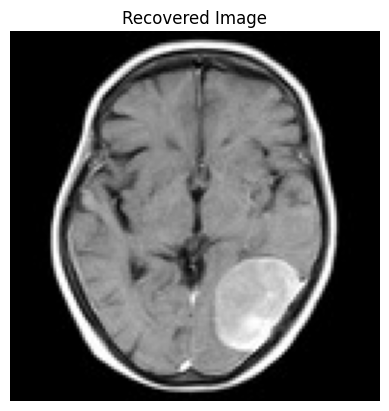

In [20]:
import matplotlib.pyplot as plt

if recovered_array1 is not None:
    plt.imshow(recovered_array1, cmap='gray')
    plt.title("Recovered Image")
    plt.axis('off')
    plt.show()


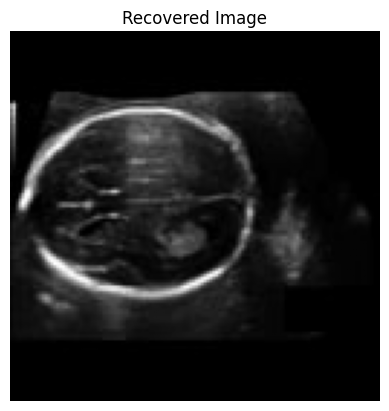

In [21]:
import matplotlib.pyplot as plt

if recovered_array2 is not None:
    plt.imshow(recovered_array2, cmap='gray')
    plt.title("Recovered Image")
    plt.axis('off')
    plt.show()


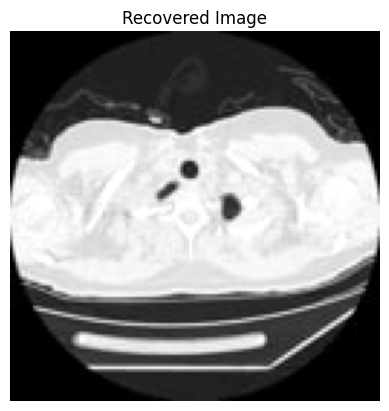

In [22]:
import matplotlib.pyplot as plt

if recovered_array3 is not None:
    plt.imshow(recovered_array3, cmap='gray')
    plt.title("Recovered Image")
    plt.axis('off')
    plt.show()


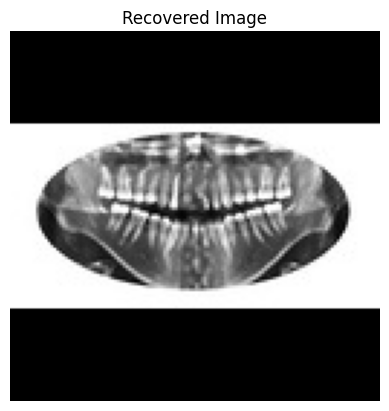

In [23]:
import matplotlib.pyplot as plt

if recovered_array4 is not None:
    plt.imshow(recovered_array4, cmap='gray')
    plt.title("Recovered Image")
    plt.axis('off')
    plt.show()


#### 3D Histogram showcasing plaintext and ciphertext 

In [ ]:
# Define labels and colors
images = ['Brain MRI', 'Fetus Ultrasound', 'Lungs CT Scan', 'Teeths X-Ray']
colors = ['b', 'g', 'r', 'c']
bins = np.arange(256)

cipher_array1 = np.frombuffer(ciphertext1, dtype=np.uint8)
cipher_array2 = np.frombuffer(ciphertext2, dtype=np.uint8)
cipher_array3 = np.frombuffer(ciphertext3, dtype=np.uint8)
cipher_array4 = np.frombuffer(ciphertext4, dtype=np.uint8)


# Plain histograms
plain_histograms = [
    np.concatenate([image_array1,image_array2,image_array3,image_array4]).clip(0, 120000).astype(int)
    for _ in images
]


C:\Users\suraj\AppData\Local\Temp\ipykernel_18624\1112092911.py:69: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


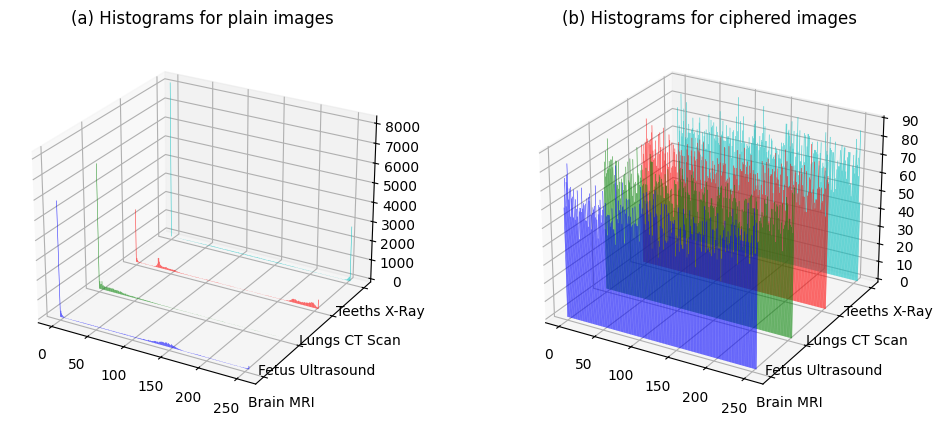

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ---------------------------------------------------
# Define labels and colors
# ---------------------------------------------------
images = ['Brain MRI', 'Fetus Ultrasound', 'Lungs CT Scan', 'Teeths X-Ray']
colors = ['b', 'g', 'r', 'c']
bins = np.arange(256)

# ---------------------------------------------------
# Convert ciphertext bytes to uint8 arrays
# ---------------------------------------------------
cipher_array1 = np.frombuffer(ciphertext1, dtype=np.uint8)
cipher_array2 = np.frombuffer(ciphertext2, dtype=np.uint8)
cipher_array3 = np.frombuffer(ciphertext3, dtype=np.uint8)
cipher_array4 = np.frombuffer(ciphertext4, dtype=np.uint8)

# ---------------------------------------------------
# Compute histograms for plain images
# ---------------------------------------------------
plain_arrays = [image_array1, image_array2, image_array3, image_array4]
plain_histograms = [
    np.histogram(img.flatten(), bins=256, range=(0, 255))[0]
    for img in plain_arrays
]

# ---------------------------------------------------
# Compute histograms for ciphered images
# ---------------------------------------------------
cipher_arrays = [cipher_array1, cipher_array2, cipher_array3, cipher_array4]
ciphered_histograms = [
    np.histogram(carr.flatten(), bins=256, range=(0, 255))[0]
    for carr in cipher_arrays
]

# ---------------------------------------------------
# Create figure and 3D subplots
# ---------------------------------------------------
fig = plt.figure(figsize=(12, 5))

# --- (a) Plain Images ---
ax1 = fig.add_subplot(121, projection='3d')
for i, (img, hist, color) in enumerate(zip(images, plain_histograms, colors)):
    xs = bins
    ys = np.full_like(xs, i)
    ax1.bar(xs, hist, zs=i, zdir='y', color=color, alpha=0.8)


ax1.set_title('(a) Histograms for plain images')
ax1.set_yticks(range(len(images)))
ax1.set_yticklabels(images)
ax1.view_init(elev=25, azim=-60)

# --- (b) Ciphered Images ---
ax2 = fig.add_subplot(122, projection='3d')
for i, (img, hist, color) in enumerate(zip(images, ciphered_histograms, colors)):
    xs = bins
    ys = np.full_like(xs, i)
    ax2.bar(xs, hist, zs=i, zdir='y', color=color, alpha=0.8)


ax2.set_title('(b) Histograms for ciphered images')
ax2.set_yticks(range(len(images)))
ax2.set_yticklabels(images)
ax2.view_init(elev=25, azim=-60)

plt.tight_layout()
plt.show()